<a href="https://www.kaggle.com/code/muratsahin1/resnet-implementation-for-blood-cells-dataset?scriptVersionId=133865818" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, BatchNormalization, ZeroPadding2D, MaxPooling2D, \
        Activation, add
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator

from glob import glob
import itertools

2.6.4


In [2]:
IMAGE_SIZE = [224, 224]

epochs = 16
batch_size = 128

In [3]:
train_path = "/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TRAIN"
test_path = "/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TEST"

In [4]:
image_files = glob(train_path + '/*/*.jp*g')
valid_image_files = glob(test_path + '/*/*.jp*g')

In [5]:
print(len(image_files))
print(len(valid_image_files))

9957
2487


In [6]:
folders = glob(train_path + '/*')

In [7]:
print(len(folders))

4


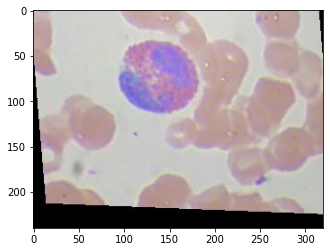

In [8]:
plt.imshow(image.load_img(np.random.choice(image_files)))

In [9]:
def identity_block(input_, kernel_size, filters):
    f1, f2, f3 = filters
    
    x = Conv2D(f1, (1,1))(input_)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(f2, kernel_size, padding = 'same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(f3, (1,1))(x)
    x = BatchNormalization()(x)
    
    x = add([x, input_])
    x = Activation('relu')(x)
    return x

In [10]:
def conv_block(input_, kernel_size, filters, strides = (2, 2)):
    f1, f2, f3 = filters
    
    x = Conv2D(f1, (1, 1), strides = strides)(input_)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(f2, kernel_size, padding = 'same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(f3, (1, 1))(x)
    x = BatchNormalization()(x)
    
    shortcut = Conv2D(f3, (1, 1), strides = strides)(input_)
    shortcut = BatchNormalization()(shortcut)
    
    x = add([x, shortcut])
    x = Activation('relu')(x)
    return x

In [11]:
i = Input (shape = IMAGE_SIZE + [3])
x = ZeroPadding2D(padding = (3, 3))(i)
x = Conv2D(64, (7, 7), strides = (2, 2), padding = 'valid')(i)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = ZeroPadding2D(padding = (1, 1))(x)
x = MaxPooling2D((3, 3), strides = (2, 2))(x)

x = conv_block(x, 3, [64, 64, 256], strides = (1, 1))
x = identity_block(x, 3, [64, 64, 256])
x = identity_block(x, 3, [64, 64, 256])

x = conv_block(x, 3, [128, 128, 512])
x = identity_block(x, 3, [128, 128, 512])
x = identity_block(x, 3, [128, 128, 512])
x = identity_block(x, 3, [128, 128, 512])

In [12]:
x = Flatten()(x)
prediction = Dense(len(folders), activation = 'softmax')(x)

In [13]:
model = Model(inputs = i, outputs = prediction)

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 109, 109, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 109, 109, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 109, 109, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [15]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = Adam(learning_rate = 0.0001),
    metrics = ['accuracy']
)

In [16]:
def preprocess_input2(x):
    x /= 127.5
    x -= 1.
    return x

In [17]:
train_gen = ImageDataGenerator(
    rotation_range = 20,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    zoom_range = 0.2,
    horizontal_flip = True,
    vertical_flip = True,
    preprocessing_function = preprocess_input2
)

val_gen = ImageDataGenerator(
    preprocessing_function = preprocess_input2
)

In [18]:
test_gen = val_gen.flow_from_directory(test_path, target_size = IMAGE_SIZE, class_mode = 'sparse')
print(test_gen.class_indices)
labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
    labels[v] = k

Found 2487 images belonging to 4 classes.
{'EOSINOPHIL': 0, 'LYMPHOCYTE': 1, 'MONOCYTE': 2, 'NEUTROPHIL': 3}


min: -1.0 max: 1.0


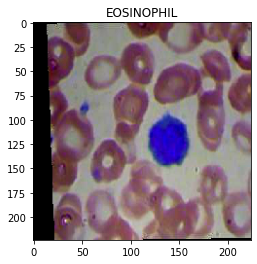

In [19]:
for x, y in test_gen:
    print("min:", x[0].min(), "max:", x[0].max())
    plt.title(labels[np.argmax(y[0])])
    plt.imshow(x[0])
    plt.show()
    break

In [20]:
train_generator = train_gen.flow_from_directory(
    train_path,
    target_size = IMAGE_SIZE,
    shuffle = True,
    batch_size = batch_size,
)

valid_generator = val_gen.flow_from_directory(
    test_path,
    target_size = IMAGE_SIZE,
    shuffle = True,
    batch_size = batch_size,
    
)

Found 9957 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.


In [21]:
import math
checkpoint_filepath = 'tmp/checkpoint'
r = model.fit(
    train_generator,
    validation_data = valid_generator,
    epochs = epochs,
    steps_per_epoch = math.floor(len(image_files) / batch_size),
    validation_steps = math.floor(len(valid_image_files) / batch_size),
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor = 'loss', patience = 3, restore_best_weights = True),
        tf.keras.callbacks.ModelCheckpoint(
            filepath = checkpoint_filepath,
            save_weights_only = True,
            monitor = 'val_accuracy',
            mode = 'max',
            save_best_only = True
        ),
    ]
)

Epoch 1/16
77/77 [==============================] - 210s 3s/step - loss: 9.1422 - accuracy: 0.2699 - val_loss: 1.3931 - val_accuracy: 0.2475
Epoch 2/16
77/77 [==============================] - 163s 2s/step - loss: 2.0880 - accuracy: 0.4043 - val_loss: 1.8634 - val_accuracy: 0.2525
Epoch 3/16
77/77 [==============================] - 164s 2s/step - loss: 1.3020 - accuracy: 0.6260 - val_loss: 2.0623 - val_accuracy: 0.2488
Epoch 4/16
77/77 [==============================] - 163s 2s/step - loss: 0.6060 - accuracy: 0.8134 - val_loss: 3.7487 - val_accuracy: 0.2566
Epoch 5/16
77/77 [==============================] - 163s 2s/step - loss: 0.4430 - accuracy: 0.8760 - val_loss: 8.6457 - val_accuracy: 0.2714
Epoch 6/16
77/77 [==============================] - 164s 2s/step - loss: 0.3862 - accuracy: 0.8990 - val_loss: 8.9194 - val_accuracy: 0.3590
Epoch 7/16
77/77 [==============================] - 161s 2s/step - loss: 0.3019 - accuracy: 0.9238 - val_loss: 11.0995 - val_accuracy: 0.3988
Epoch 8/16
7

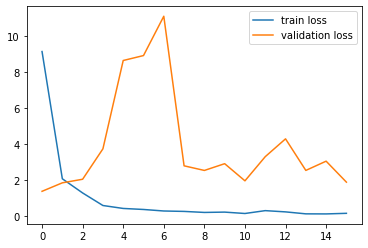

In [22]:
plt.plot(r.history['loss'], label = 'train loss')
plt.plot(r.history['val_loss'], label = 'validation loss')
plt.legend()
plt.show()

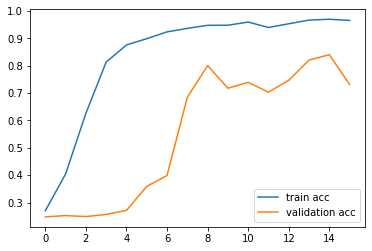

In [23]:
plt.plot(r.history['accuracy'], label = 'train acc')
plt.plot(r.history['val_accuracy'], label = 'validation acc')
plt.legend()
plt.show()

In [24]:
model.load_weights(checkpoint_filepath) # Getting the best model we got during the training process

In [25]:
def get_confusion_matrix(data_path, N):
  # we need to see the data in the same order
  # for both predictions and targets
  print("Generating confusion matrix", N)
  predictions = []
  targets = []
  i = 0
  for x, y in val_gen.flow_from_directory(data_path, target_size=IMAGE_SIZE, shuffle=False, batch_size=batch_size * 2):
    i += 1
    if i % 50 == 0:
      print(i)
    p = model.predict(x)
    p = np.argmax(p, axis=1)
    y = np.argmax(y, axis=1)
    predictions = np.concatenate((predictions, p))
    targets = np.concatenate((targets, y))
    if len(targets) >= N:
      break

  cm = confusion_matrix(targets, predictions)
  return cm

In [26]:
model.load_weights('/kaggle/working/tmp/checkpoint')

In [27]:
cm = get_confusion_matrix(train_path, len(image_files))
print(cm)

Generating confusion matrix 9957
Found 9957 images belonging to 4 classes.
[[2238   19    0  240]
 [   0 2474    0    9]
 [   0  105 2365    8]
 [  32   17    0 2450]]


In [28]:
valid_cm = get_confusion_matrix(test_path, len(valid_image_files))
print(valid_cm)

Generating confusion matrix 2487
Found 2487 images belonging to 4 classes.
[[455   8   0 160]
 [  0 610  10   0]
 [  0   0 465 155]
 [ 50  12   0 562]]
